In [1]:
!pip install albumentations

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from albumentations import RandomRotate90
from tensorflow.keras import mixed_precision
import gc

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
def Read_Data(path,is_train = True):
  temp = []
  updated_path = os.path.join(path,"VOC2012_train_val","VOC2012_train_val","ImageSets","Segmentation","train.txt" if is_train else "val.txt")
  with open(updated_path,"r") as file_:
    Instances = file_.read().split()
    for img in Instances:
      path_img = os.path.join(path,"VOC2012_train_val","VOC2012_train_val","JPEGImages",img+".jpg")
      path_label = os.path.join(path,"VOC2012_train_val","VOC2012_train_val","SegmentationClass",img+".png")
      temp.append([path_img,path_label])
  return temp

In [5]:
path = '../input/pascal-voc-2012-dataset'
Train = Read_Data(path=path,is_train=True)
Val = Read_Data(path=path,is_train=False)

In [6]:
Train = tf.random.shuffle(Train)
Val = tf.random.shuffle(Val)

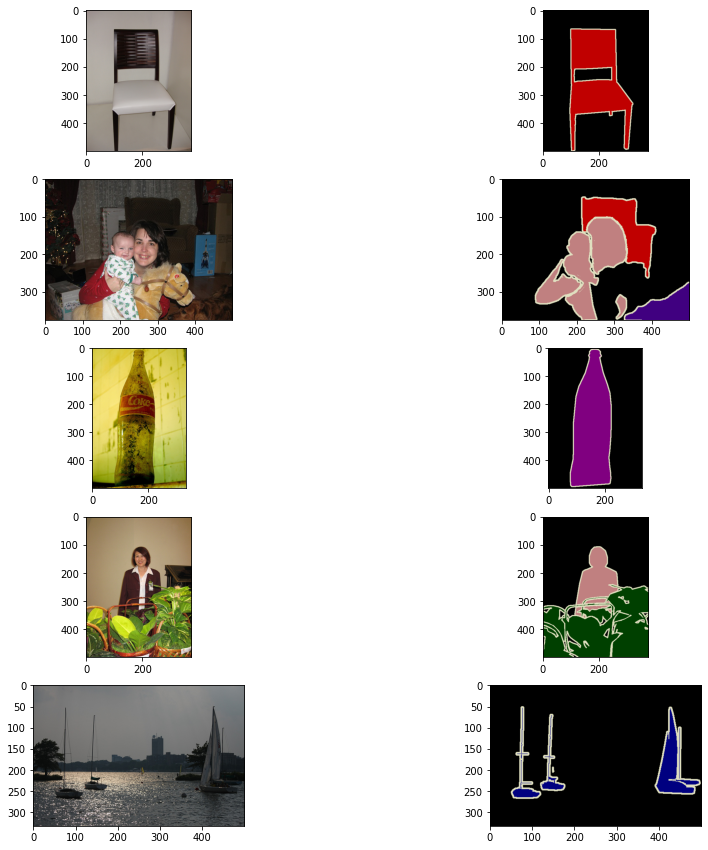

In [7]:
plt.figure(figsize=(15,15))
idx = 0
img = 0
mask = 0
for instance in Train[:5].numpy():
  plt.subplot(5,2,idx+1)  
  img = Image.open(instance[0])
  plt.imshow(img)
  plt.subplot(5,2,idx+2)  
  mask = Image.open(instance[1])
  plt.imshow(mask)
  idx += 2

In [8]:
num_classes = 21
Img_Width,Img_Height = 224,224
Train = tf.data.Dataset.from_tensor_slices(Train)
Val = tf.data.Dataset.from_tensor_slices(Val)
mixed_precision.set_global_policy('mixed_float16')

In [9]:
def Create_Mask(Img):
  Seg_Labels = np.zeros((Img.shape[0],Img.shape[1],num_classes),dtype=np.float16)
  for class_ in range(num_classes):
    Seg_Labels[:,:,class_] = (Img == class_)
  return tf.cast(Seg_Labels,dtype=tf.float16)

In [10]:
def Create_PreProcess_Mask_Img(Instance):
 
  Img = Image.open(Instance[0].numpy())
  Img = Img.resize((Img_Width,Img_Height),resample = Image.BILINEAR)
  Img = np.asarray(Img)

  Mask = Image.open(Instance[1].numpy())
  Mask = Mask.resize((Img_Width,Img_Height),resample = Image.BILINEAR)
  Mask = np.asarray(Mask)   
   
  # Since Mask is in 'P' mode it will automatically convert to labels using Color Palette 

  Normalization = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

  if tf.random.uniform(()) > 0.5:  # Applying data Augmentation
    aug = RandomRotate90(p=0.5)
    Augmented = aug(image = Img,mask = Mask)

    Img = Augmented["image"]
    Mask = Augmented["mask"]
  
  return Normalization(Img),Create_Mask(Mask)

In [11]:
def Preprocess(Instance):
  Img,Mask = tf.py_function(Create_PreProcess_Mask_Img,[Instance],[tf.float16,tf.float16])
  return tf.ensure_shape(Img,[None,None,3]),tf.ensure_shape(Mask,[None,None,num_classes])  
  #tf.ensure_shape returns the matrix if shape matches else error

In [12]:
def DataLoader(dataset,BATCH_SIZE = 2,BUFFER_SIZE = 2):
  data = dataset.map(Preprocess,num_parallel_calls = tf.data.AUTOTUNE)
  data = data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(1)
  data = data.prefetch(buffer_size = tf.data.AUTOTUNE)
  return data

In [13]:
Train = DataLoader(Train)
Val = DataLoader(Val)

In [14]:
Q = []
for X,Y in Val.take(1):
  print(X.shape)
  Q = Y
  print(Y.shape)

(2, 224, 224, 3)
(2, 224, 224, 21)


In [15]:
Q.dtype

tf.float16

In [16]:
# Lets Create Our FCN Model
def FCN_VGG8():

  Input = tf.keras.layers.Input(shape = [Img_Width,Img_Height,3])
  Conv1 = tf.keras.layers.Conv2D(64,kernel_size=3,strides = 1,padding="same",activation="relu")(Input)
  Conv2 = tf.keras.layers.Conv2D(64,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv1)
  Pool1 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(Conv2)

  Conv3 = tf.keras.layers.Conv2D(128,kernel_size=3,strides = 1,padding="same",activation="relu")(Pool1)
  Conv4 = tf.keras.layers.Conv2D(128,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv3)
  Pool2 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(Conv4)

  Conv5 = tf.keras.layers.Conv2D(256,kernel_size=3,strides = 1,padding="same",activation="relu")(Pool2)
  Conv6 = tf.keras.layers.Conv2D(256,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv5)
  Conv7 = tf.keras.layers.Conv2D(256,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv6)
  Pool3 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(Conv7)

  Conv8 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Pool3)
  Conv9 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv8)
  Conv10 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv9)
  Pool4 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(Conv10)

  Conv11 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Pool4)
  Conv12 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv11)
  Conv13 = tf.keras.layers.Conv2D(512,kernel_size=3,strides = 1,padding="same",activation="relu")(Conv12)
  Pool5 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(Conv13)

  # Fully Convolutional Layer

  FC_Layer = tf.keras.layers.Conv2D(4096,kernel_size=7,activation="relu")(Pool5)
  FC_Drop = tf.keras.layers.Dropout(rate=0.5)(FC_Layer)
  FC_Layer2 = tf.keras.layers.Conv2D(4096,kernel_size=1,activation="relu")(FC_Drop)
  FC_Drop2 = tf.keras.layers.Dropout(rate=0.5)(FC_Layer2)

  # Classification Score Layer
  Score = tf.keras.layers.Conv2D(num_classes,kernel_size=1,activation="relu")(FC_Drop2)
 

  #Upsample Pool4

  Upscore = tf.keras.layers.Conv2DTranspose(num_classes,kernel_size=4,strides=2,kernel_initializer="zeros")(Score)
  
  Conv_Scale = tf.keras.layers.Conv2D(num_classes,kernel_size=1)(Pool4)
  Cropped = tf.keras.layers.Cropping2D(cropping=(5,5))(Conv_Scale)

  Fused = tf.keras.layers.add([Cropped,Upscore])
  
  Upsampled_Pool4 = tf.keras.layers.Conv2DTranspose(num_classes,kernel_size=4,strides=2,kernel_initializer="zeros")(Fused)

  
  # Upsample Pool3

  Conv_Scale2 = tf.keras.layers.Conv2D(num_classes,kernel_size=1)(Pool3)
  Cropped2 = tf.keras.layers.Cropping2D(cropping=(9,9))(Conv_Scale2)
  Fused2 = tf.keras.layers.add([Cropped2,Upsampled_Pool4])

  Upsampled_Pool3 = tf.keras.layers.Conv2DTranspose(num_classes,kernel_size=128,strides=16,kernel_initializer="zeros")(Fused2)

  # Score per Pixel

  Score = tf.keras.layers.Cropping2D(cropping=(24,24))(Upsampled_Pool3)
  Score = tf.keras.layers.Softmax(dtype = "float32")(Score)

  return tf.keras.Model(inputs = Input,outputs = Score)


In [17]:
model = FCN_VGG8()

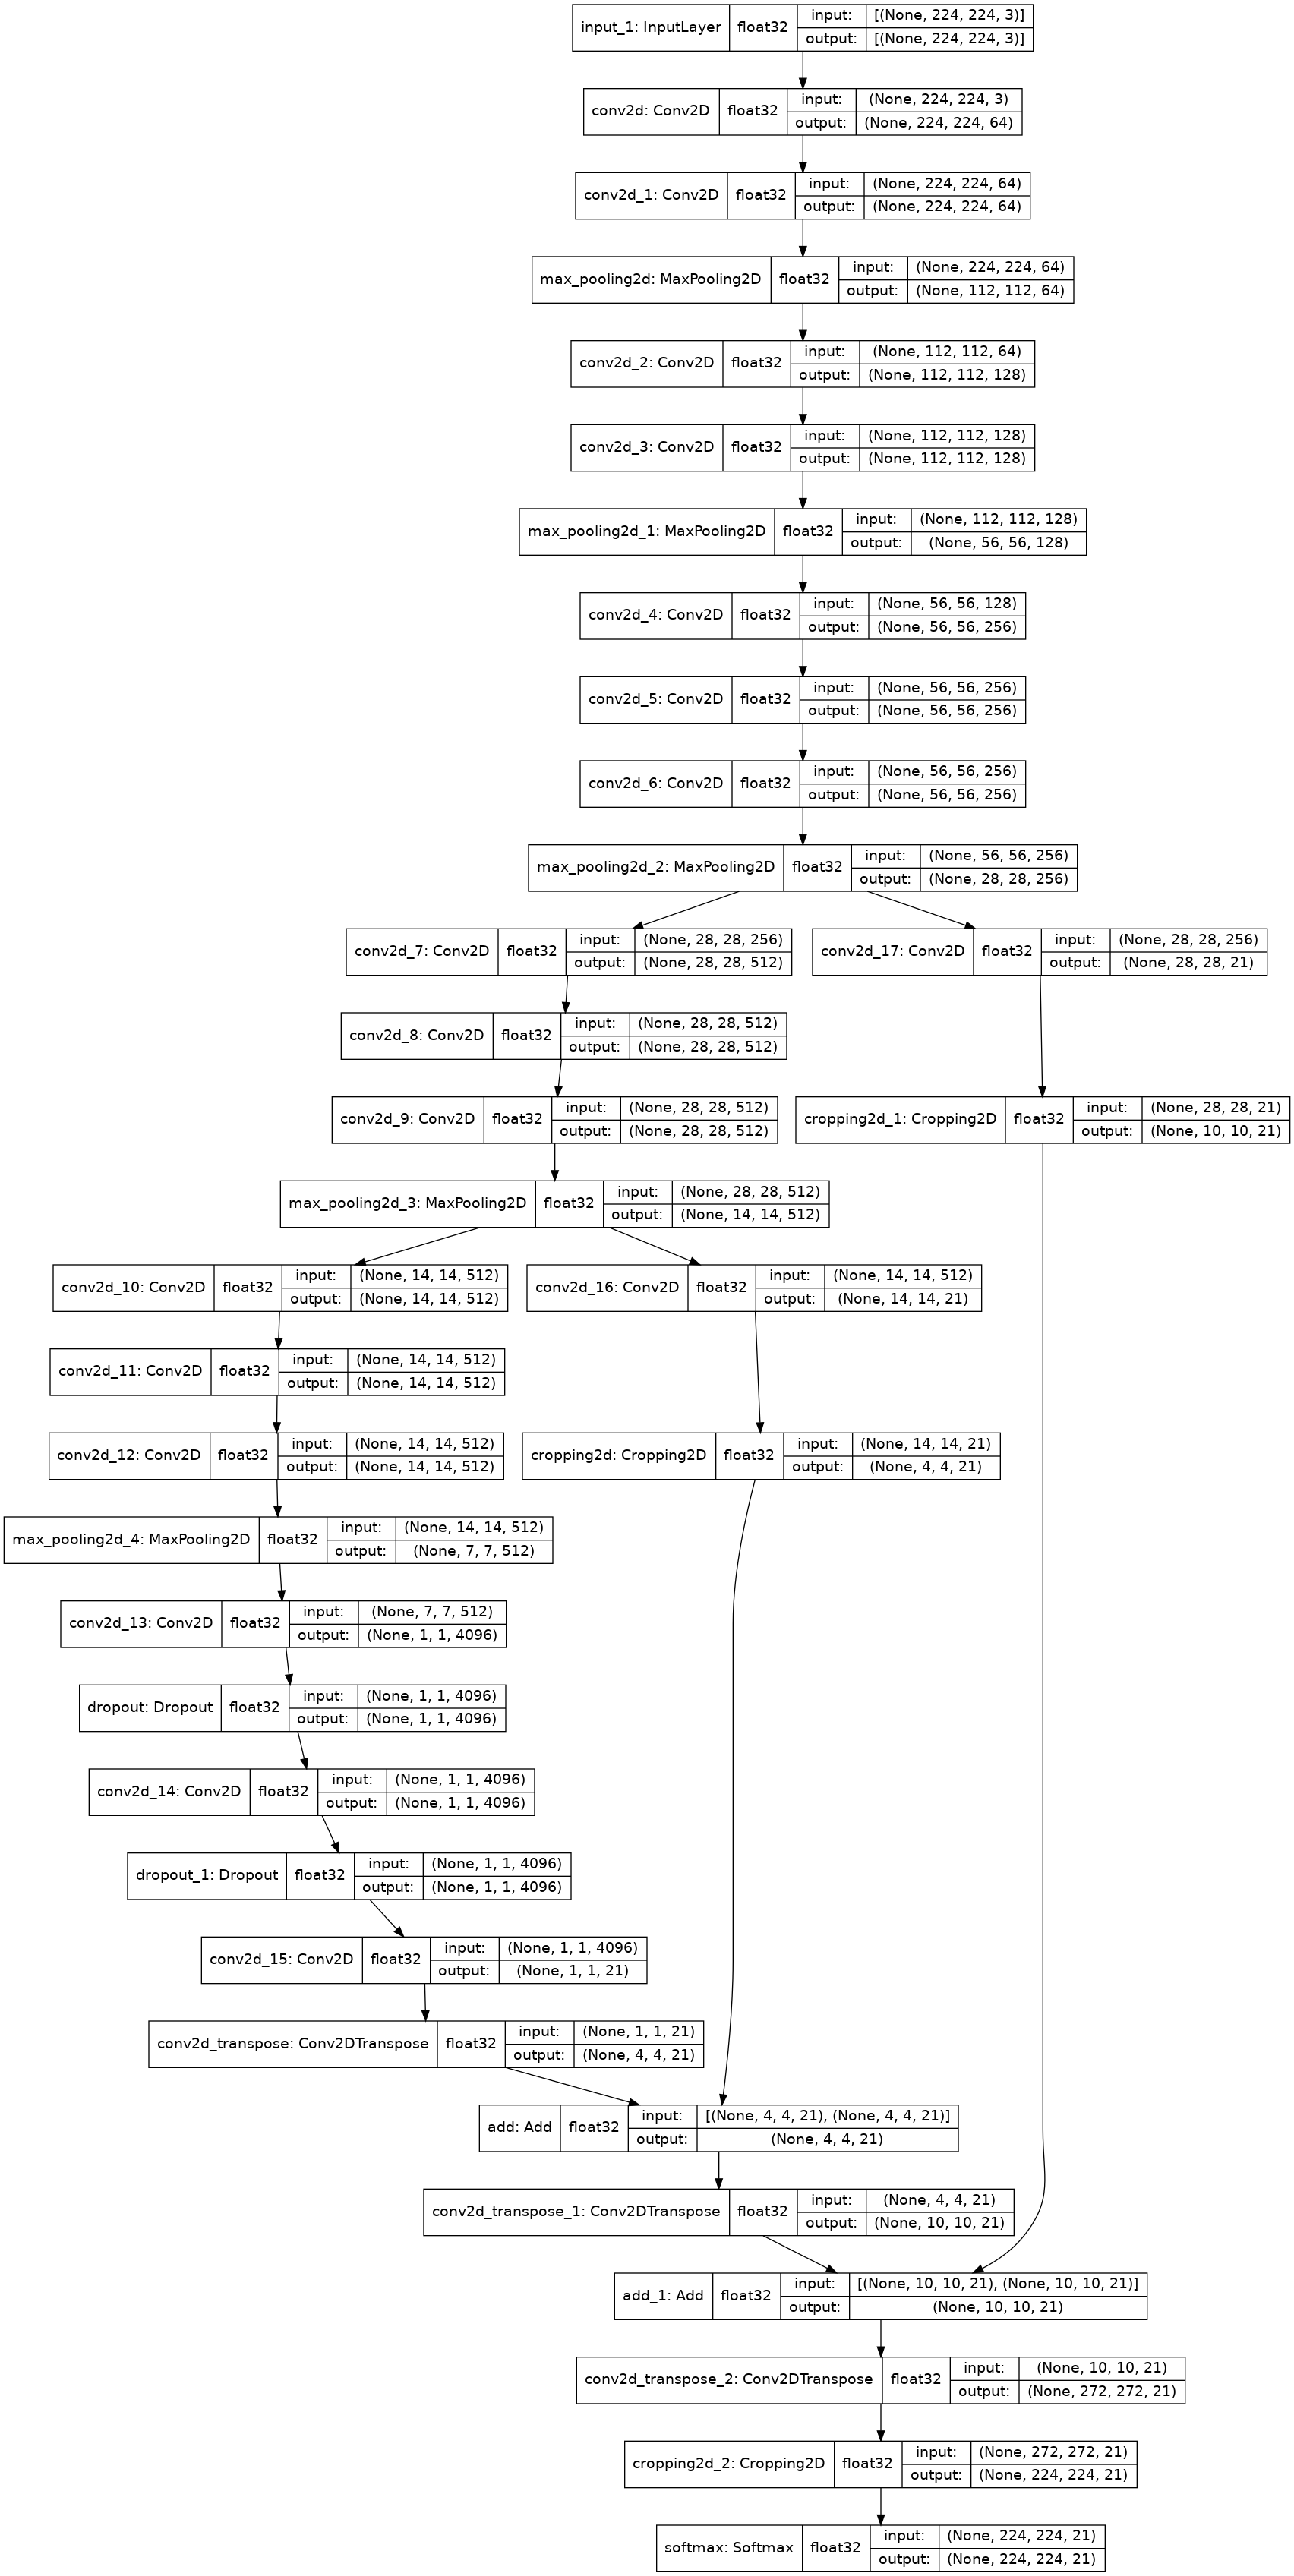

In [18]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
VGG16 = tf.keras.applications.vgg16.VGG16(weights='imagenet')
VGG16.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [21]:
model.layers[:19]

In [22]:
for i in model.layers:
    print(i.dtype_policy)

<Policy "float32">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "float32">


In [23]:
for i in range(19):
  model.layers[i].set_weights(VGG16.layers[i].get_weights())

In [24]:
root_dir = os.path.join(os.curdir,"my_logs")

def get_path():
    import time
    id_ = time.strftime("run_%Y_%m_%D_%H_%M_%S")
    return os.path.join(root_dir,id_)

board_log_path = get_path()

In [25]:
for layers in model.layers[:19]:
  layers.trainable = False

In [26]:
EarlyStop = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights=True)
checkpoint_path = os.path.join(os.curdir,"checkpoint")
Checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True)
Tensorboard = tf.keras.callbacks.TensorBoard(board_log_path)

MeanIou = tf.keras.metrics.MeanIoU(num_classes=21)

In [27]:
gc.collect()
gc.enable()

In [28]:
tf.keras.backend.clear_session()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4,momentum=0.9),loss=tf.keras.losses.categorical_crossentropy,metrics=[MeanIou])

In [30]:
Epochs = 100
Batchsize = 2

history = model.fit(Train,validation_data=Val,batch_size=Batchsize,epochs=Epochs,callbacks=[EarlyStop,Checkpoint,Tensorboard])

Epoch 1/100
732/732 [==============================] - 187s 248ms/step - loss: 1.9897 - mean_io_u: 0.4776 - val_loss: 1.6192 - val_mean_io_u: 0.4775
Epoch 2/100
732/732 [==============================] - 127s 174ms/step - loss: 1.6058 - mean_io_u: 0.4776 - val_loss: 1.5466 - val_mean_io_u: 0.4775
Epoch 3/100
732/732 [==============================] - 127s 174ms/step - loss: 1.5417 - mean_io_u: 0.4776 - val_loss: 1.4998 - val_mean_io_u: 0.4775
Epoch 4/100
732/732 [==============================] - 128s 175ms/step - loss: 1.4971 - mean_io_u: 0.4776 - val_loss: 1.4621 - val_mean_io_u: 0.4775
Epoch 5/100
732/732 [==============================] - 128s 175ms/step - loss: 1.4596 - mean_io_u: 0.4776 - val_loss: 1.4319 - val_mean_io_u: 0.4775
Epoch 6/100
732/732 [==============================] - 128s 175ms/step - loss: 1.4311 - mean_io_u: 0.4776 - val_loss: 1.4088 - val_mean_io_u: 0.4775
Epoch 7/100
732/732 [==============================] - 128s 175ms/step - loss: 1.4085 - mean_io_u: 0.4776 

KeyboardInterrupt: 

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10,8))
plt.grid('True')
plt.savefig("Learning_Curve_Model1.png")
plt.show()

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
Epochs = 300
Batchsize = 2

history = model.fit(Train,validation_data=Val,batch_size=Batchsize,epochs=Epochs,callbacks=[EarlyStop,Checkpoint,Tensorboard])

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10,8))
plt.grid('True')
plt.savefig("Learning_Curve_Model1.png")
plt.show()